Slick algorithms and whiz-bang math are nice to have, but sometimes nothing speaks as well as a hardware demo. And for energy nerds, this means flashing lights. Rather than wrangling an Arduino and working with LEDs, another option is to get a quick start using 'smart' WiFi-controllable lightbulbs and a Python package to control them.

Based on their low price and Python support with the [Pywemo package](https://github.com/pavoni/pywemo/tree/master/pywemo), I picked up a set of Belkin Wemo bulbs and have been using them for demos. As I couldn't find a great demo of how to control them, I'm sharing my learnings in this tutorial.

**Why you might want to use Wemo smart bulbs:**
- Low price
- Good open-source software controls
- Popular smart switch

**Why not to use Wemo smart bulbs:**
- Limited support: see notes below
- Designed for home applications; limited wifi configurability

**Bulbs which work with the Wemo Link bridge:** 
- Belkin Wemo bulbs (no longer sold separately; only available with starter kit)
- Sylvania Lightify A19 'tunable white' bulbs
- Sylvania Lightify A19 'Tunable Color' bulbs (not tested).
- Cree Connected Soft White dimmable LED Bulb (not tested).
- Note: The standard non-tunable white Lightify bulb **does not support the Wemo Link**

The smart device space is changing fast, and there is not good interoperability between manufacturers due to differences in their underlying zigbee protocols. Even Sylvania/Osram and Belkin, who had been collaborating on the WeMo bulbs, no longer have full compatability between their bulbs.

Some of the other manufacturers with smart bulbs and Python support are:
- Philips Hue and [Phue python package](https://github.com/studioimaginaire/phue)
- LIFX and [Lifxlan python package](https://github.com/mclarkk/lifxlan)

If you know of others, let me know! I haven't explored the [open-source Home Assistant app](https://home-assistant.io) and python hooks, but this may be another useful route.

If I had to do this again, I would go with Phillips (more likely to have forward support), or a Samsung SmartThings base (broader support for a variety of devices).

### Understanding Ouimeaux and Pywemo
Ouimeaux is an underlying API interface that provids hooks for communicating with all of the WeMo devices (and others). Pywemo is an extension package which runs on top of ouimeaux and provides functionality for Wemo devices (especially smart bulbs). The raw ouimeaux package does not allow for controlled dimming or tuning light color. **Bottom line:** If you want to dim a set of smart bulbs, go with the pywemo package

Note: I've [submitted a pull request](https://github.com/pavoni/pywemo/pull/71) to fix a bug that affected color tuning in the Sylvania Lightify Tunable White bulb. Work with the github version until this is released to Pip.

### Setup
If you're using these for demos (and not on a home network) you'll need to get used to resetting the WeMo Link and lightbulbs. Note that the WeMo app doesn't support token-based device authentication or authentication portals, so won't work on many commercial networks (hotels, universities). As a workaround, I've sometimes created an ad-hoc network using a cell phone, and connected the WeMo Link and my laptop to this cell phone network.

**Wemo Link light codes:**
- Alternating orange and green: Ready to setup; connect to ad-hoc wifi and set up wifi via the WeMo mobile app (ad-hoc wifi SSID is like 'WeMo.Link.A01'
- Flashing green: Startup mode after being unplugged; working on connecting to WiFi and bulbs
- Flashing orange: Disconnected from WiFi or unable to find network
- No lights: Working

**Changing WiFi networks:**
- Reset the WeMo Link (remove from outlet, press down reset button, plug in outlet, wait ~10s, release reset button, wait until alternating orange and green)
- Use mobile device to connect to WeMo link's ad-hoc WiFi network
- Launch WeMo app and set up WiFi preferences for Link
- While Link is searching, reset the bulbs: Unplug for 1s, plug in for 3s... and repeat 3-5 times.
- When bulbs have been reset, they will flash to indicate that they have reset
- Bulbs should appear in WeMo Link app search screen. If not, reset again.



In [1]:
import pywemo
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

print("Current environment directory:" + sys.prefix)
print("System version: "+sys.version)
print("Current working directory: "+os.getcwd())

Current environment directory:/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7
System version: 2.7.12 (default, Aug 23 2016, 08:54:23) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]
Current working directory: /Users/emunsing/GoogleDrive/Papers/EnergyBlockchain/Coding


After making sure that we're on the same network as the WeMo bridge and that the bridge is on (using the WeMo app), we need to discover the WeMo devices on the network.

In [2]:
devices = pywemo.discover_devices()
devices

/usr/local/lib/python2.7/site-packages/pywemo/ssdp.py:142: FutureWarning: The behavior of this method will change in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if tree:


[<WeMo Bridge "WeMo Link", Lights: 3, Groups: 0>]

Great- we have a WeMo Link, which has some child Lights: we get details on that by accessing the `.Lights` property, which returns a dictionary keyed with the serial numbers of the lights:

In [3]:
devices[0].Lights

{'8418260000053C9D': <LIGHT "Color Light 01">,
 '94103EF6BF42C290': <LIGHT "Lightbulb 03">,
 '94103EF6BF439599': <LIGHT "Lightbulb 02">}

Serial numbers are a bit difficult to remember, and what matters is the `LIGHT` objects... so let's zip these up into a dictionary with names of our own creation:

In [4]:
lights = dict(zip(['bedroom','kitchen','bathroom'],devices[0].Lights.values()))
lights

{'bathroom': <LIGHT "Color Light 01">,
 'bedroom': <LIGHT "Lightbulb 03">,
 'kitchen': <LIGHT "Lightbulb 02">}

We can now turn these on and off:

In [5]:
lights['bedroom'].toggle()
time.sleep(3)
lights['bedroom'].toggle()

<LIGHT "Lightbulb 03">

Note that we need to sleep between commands, as the lights won't buffer commands but instead will execute the requests as soon as they are recieved.

If we don't want to toggle them, we can force them to be either on or off:

In [6]:
lights['bedroom'].turn_on(transition=2)
time.sleep(2.1)
lights['bedroom'].turn_off()

<LIGHT "Lightbulb 03">

For color-tunable lightbulbs, the `.set_temperature()` (and `.set_color`) methods provide the ability to specify a temperature. I've only worked with the temperature tunable Sylvania Lightify bulb, which appears to be tunable in the range of 2700-6500 Kelvin.

In [7]:
lights['bathroom'].turn_off()
lights['bathroom'].set_temperature(kelvin=2700, delay=False)
lights['bathroom'].turn_on()
time.sleep(0.5)
lights['bathroom'].set_temperature(kelvin=6500,transition=2,delay=False)
time.sleep(2.2)
lights['bathroom'].set_temperature(kelvin=2700,transition=2,delay=False)
time.sleep(2.2)

We can additionally control of brightness using the optional `level` argument of the `turn_on` method. Values for `level` should be in the range 0-255. Add this to a loop, and we can start to have some fun visualizations:

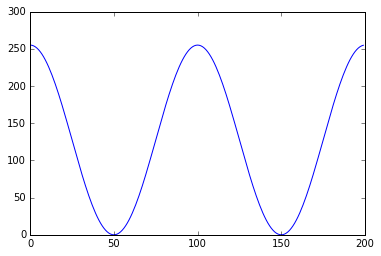

In [8]:
max_brightness = 255
x = np.arange(0,2,0.01)
brightness = np.cos(2*np.pi * x)*max_brightness/2. + max_brightness/2.
plt.plot(brightness)

In [9]:
for y in brightness:
    lights['bathroom'].turn_on(level=y,transition=0.1,force_update=True)
    time.sleep(0.11)

Note that the light shuts off when `level=0` and switches back on as soon as level is positive- this is not a continuous mapping as might be expected. Also, you may want to cap the brightness of the lightbulbs, or use a shade (an upside down paper coffee cup is a convenient lampshade)

Put it together, and we can have a simple combined visualization with changing both temperature and brightness:

In [10]:
temp_range = 6500-2700
temp_base = 2700
temperature = np.cos(np.pi * x)*temp_range*0.5 + temp_range*0.5 + temp_base

for i in range(len(x)):
    lights['bathroom'].set_temperature(kelvin=temperature[i], delay=False)
    lights['bathroom'].turn_on(level=brightness[i],transition=0.1,force_update=True)

I haven't played with Groups, but the functionality is supported- check out `bridge.py` in the pywemo project!